### <font color="green"> RNN Model for Stock prediction using stock data and 50 news Vectors</font>

**Import Libraries**

In [ ]:
#Import Libraries
import math
import time
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prep
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

**Get the Stock Data and Visualize**

In [ ]:
#Fetch data from Yahoo finance 
df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#To get the stock data for companies Tesla, AMD and Dis uncomment the respective lines below
#df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('AMD', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#df = web.DataReader('DIS', data_source='yahoo', start='2012-01-01', end='2019-12-31') 
#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,24.825001,24.577499,24.815001,24.665001,113254800.0,22.927588
2016-07-25,24.709999,24.230000,24.562500,24.334999,161531600.0,22.620825
2016-07-26,24.492500,24.105000,24.205000,24.167500,224959200.0,22.465128
2016-07-27,26.087500,25.687500,26.067499,25.737499,369379200.0,23.924532
2016-07-28,26.112499,25.705000,25.707500,26.084999,159479200.0,24.247555


In [ ]:
#Import encoded 50 vectors
newsScores=pd.read_csv('encoded_vec_aapl.csv')
newsScores.head(3)
len(newsScores)

739

In [ ]:
df1=df.reset_index()
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-07-22,24.825001,24.577499,24.815001,24.665001,113254800.0,22.927588
1,2016-07-25,24.709999,24.230000,24.562500,24.334999,161531600.0,22.620825
2,2016-07-26,24.492500,24.105000,24.205000,24.167500,224959200.0,22.465128


In [ ]:
#Combine encoded vectors and new data
newsScores['date'] = pd.to_datetime(newsScores['date'])
merged_data = pd.merge(left=df1, right=newsScores, left_on='Date', right_on='date') #merge datasets
merged_data.drop(['date'], axis=1,inplace=True) #remove redundant column
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,vec31,vec32,vec33,vec34,vec35,vec36,vec37,vec38,vec39,vec40,vec41,vec42,vec43,vec44,vec45,vec46,vec47,vec48,vec49
0,2020-03-03,76.0,71.449997,75.917503,72.330002,319475600.0,71.297157,0.0,0.002669,0.000000,0.045312,0.0,0.061592,0.000000,0.093812,0.000000,0.000000,0.058963,0.006377,0.040233,0.109778,0.030692,0.0,0.118871,0.000000,0.241402,0.000000,0.000000,0.0,0.235901,0.0,0.050056,0.107340,0.000000,0.242024,0.125376,0.138959,0.267359,0.036278,0.11992,0.0,0.0,0.0,0.03111,0.0,0.000000,0.014939,0.024877,0.162755,0.0,0.0,0.0,0.115664,0.0,0.000000,0.054035,0.0
1,2020-03-03,76.0,71.449997,75.917503,72.330002,319475600.0,71.297157,0.0,0.089528,0.196828,0.000000,0.0,0.153469,0.065338,0.047110,0.028119,0.114336,0.000000,0.000000,0.000000,0.057658,0.099029,0.0,0.110739,0.085906,0.108024,0.079100,0.035749,0.0,0.072800,0.0,0.000000,0.004640,0.015178,0.000000,0.000000,0.006349,0.173912,0.104146,0.00000,0.0,0.0,0.0,0.00000,0.0,0.105642,0.000000,0.175570,0.080777,0.0,0.0,0.0,0.067377,0.0,0.096373,0.152233,0.0
2,2020-03-03,76.0,71.449997,75.917503,72.330002,319475600.0,71.297157,0.0,0.089838,0.218770,0.000000,0.0,0.159350,0.181173,0.132517,0.000000,0.000000,0.000000,0.000000,0.041269,0.000000,0.124308,0.0,0.072705,0.139035,0.061494,0.075962,0.000000,0.0,0.137016,0.0,0.000000,0.064313,0.011120,0.000000,0.000000,0.005142,0.222803,0.109749,0.00000,0.0,0.0,0.0,0.00000,0.0,0.071746,0.000000,0.293288,0.098997,0.0,0.0,0.0,0.040393,0.0,0.176485,0.170884,0.0


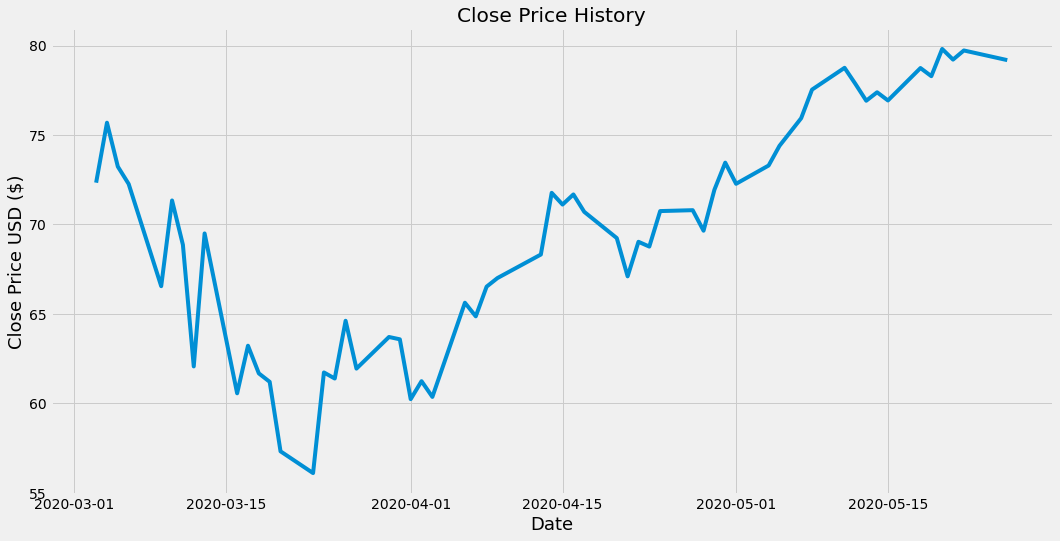

In [ ]:
#Visualize data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(merged_data['Date'],merged_data['Close'] )
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [ ]:
#Remove extra columns
type(merged_data)
data = merged_data
del data['Volume']
del data['Adj Close']
del data['Low']
del data ['High']
del data ['Open']
data.head(3)

,Date,Close,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,vec31,vec32,vec33,vec34,vec35,vec36,vec37,vec38,vec39,vec40,vec41,vec42,vec43,vec44,vec45,vec46,vec47,vec48,vec49
0,2020-03-03,72.330002,0.0,0.002669,0.000000,0.045312,0.0,0.061592,0.000000,0.093812,0.000000,0.000000,0.058963,0.006377,0.040233,0.109778,0.030692,0.0,0.118871,0.000000,0.241402,0.000000,0.000000,0.0,0.235901,0.0,0.050056,0.107340,0.000000,0.242024,0.125376,0.138959,0.267359,0.036278,0.11992,0.0,0.0,0.0,0.03111,0.0,0.000000,0.014939,0.024877,0.162755,0.0,0.0,0.0,0.115664,0.0,0.000000,0.054035,0.0
1,2020-03-03,72.330002,0.0,0.089528,0.196828,0.000000,0.0,0.153469,0.065338,0.047110,0.028119,0.114336,0.000000,0.000000,0.000000,0.057658,0.099029,0.0,0.110739,0.085906,0.108024,0.079100,0.035749,0.0,0.072800,0.0,0.000000,0.004640,0.015178,0.000000,0.000000,0.006349,0.173912,0.104146,0.00000,0.0,0.0,0.0,0.00000,0.0,0.105642,0.000000,0.175570,0.080777,0.0,0.0,0.0,0.067377,0.0,0.096373,0.152233,0.0
2,2020-03-03,72.330002,0.0,0.089838,0.218770,0.000000,0.0,0.159350,0.181173,0.132517,0.000000,0.000000,0.000000,0.000000,0.041269,0.000000,0.124308,0.0,0.072705,0.139035,0.061494,0.075962,0.000000,0.0,0.137016,0.0,0.000000,0.064313,0.011120,0.000000,0.000000,0.005142,0.222803,0.109749,0.00000,0.0,0.0,0.0,0.00000,0.0,0.071746,0.000000,0.293288,0.098997,0.0,0.0,0.0,0.040393,0.0,0.176485,0.170884,0.0


In [ ]:
del data ['Date']
data.head(3)

,Close,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19,vec20,vec21,vec22,vec23,vec24,vec25,vec26,vec27,vec28,vec29,vec30,vec31,vec32,vec33,vec34,vec35,vec36,vec37,vec38,vec39,vec40,vec41,vec42,vec43,vec44,vec45,vec46,vec47,vec48,vec49
0,72.330002,0.0,0.002669,0.000000,0.045312,0.0,0.061592,0.000000,0.093812,0.000000,0.000000,0.058963,0.006377,0.040233,0.109778,0.030692,0.0,0.118871,0.000000,0.241402,0.000000,0.000000,0.0,0.235901,0.0,0.050056,0.107340,0.000000,0.242024,0.125376,0.138959,0.267359,0.036278,0.11992,0.0,0.0,0.0,0.03111,0.0,0.000000,0.014939,0.024877,0.162755,0.0,0.0,0.0,0.115664,0.0,0.000000,0.054035,0.0
1,72.330002,0.0,0.089528,0.196828,0.000000,0.0,0.153469,0.065338,0.047110,0.028119,0.114336,0.000000,0.000000,0.000000,0.057658,0.099029,0.0,0.110739,0.085906,0.108024,0.079100,0.035749,0.0,0.072800,0.0,0.000000,0.004640,0.015178,0.000000,0.000000,0.006349,0.173912,0.104146,0.00000,0.0,0.0,0.0,0.00000,0.0,0.105642,0.000000,0.175570,0.080777,0.0,0.0,0.0,0.067377,0.0,0.096373,0.152233,0.0
2,72.330002,0.0,0.089838,0.218770,0.000000,0.0,0.159350,0.181173,0.132517,0.000000,0.000000,0.000000,0.000000,0.041269,0.000000,0.124308,0.0,0.072705,0.139035,0.061494,0.075962,0.000000,0.0,0.137016,0.0,0.000000,0.064313,0.011120,0.000000,0.000000,0.005142,0.222803,0.109749,0.00000,0.0,0.0,0.0,0.00000,0.0,0.071746,0.000000,0.293288,0.098997,0.0,0.0,0.0,0.040393,0.0,0.176485,0.170884,0.0


In [ ]:
#Converting the dataframe to a numpy array
new_data = merged_data.filter(['Close']).values
dataset = data.values
#Compute training data length
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Data sclaing using minmax scaler
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
newScaler = MinMaxScaler(feature_range=(0, 1))
new_scaled_date = newScaler.fit_transform(new_data)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i])
  y_train.append(train_data[i,0])
print(x_train[0])
print(y_train[0])

[[0.68469325 0.         0.00611759 ... 0.         0.10280775 0.        ]
 [0.68469325 0.         0.20519233 ... 0.36776596 0.28963987 0.        ]
 [0.68469325 0.         0.20590251 ... 0.6734807  0.32512664 0.        ]
 ...
 [0.5382668  0.         0.         ... 0.5332857  0.         0.08843118]
 [0.5382668  0.07608615 0.         ... 0.48689224 0.27173411 0.        ]
 [0.5382668  0.         0.00447232 ... 0.7764088  0.         0.1544888 ]]
0.5382668038874359


In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#test_data = scaled_data[training_data_len: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , 0 ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i])
print(x_test[0])

[[0.73192053 0.         0.27165636 ... 0.07501376 0.13453212 0.        ]
 [0.73192053 0.         0.         ... 0.         0.30447557 0.        ]
 [0.73192053 0.         0.         ... 0.         0.25253673 0.        ]
 ...
 [0.83670653 0.         0.06250454 ... 0.         0.49014666 0.        ]
 [0.83670653 0.         0.         ... 0.         0.         0.        ]
 [0.83670653 0.         0.         ... 0.         0.29453237 0.        ]]


In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
print(x_test.shape)

(122, 60, 51)


**RNN**

In [ ]:
#Model creation
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another GRU layer
    model.add(GRU(units=512, return_sequences=True,input_shape=(x_train.shape[1], 51)))
    model.add(Dropout(0.2))

    model.add(GRU(units=256))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
#Test and Train data shape
print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (428, 60, 51)
y_train (428,)
X_test (122, 60, 51)
y_test (122,)


In [ ]:
#Compiling the model
window = 60
model = build_model([1, window, 100, 1])

Compilation Time :  0.012713909149169922


In [ ]:
#Model training
model.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=1)

428/428 [==============================] - 73s 172ms/step - loss: 0.0534 - accuracy: 0.0164


In [ ]:
#Test the train model using test data
predictions = model.predict(x_test) 
predictions = newScaler.inverse_transform(predictions)

In [ ]:
#Calculating rmse
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

5.278151181870606

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


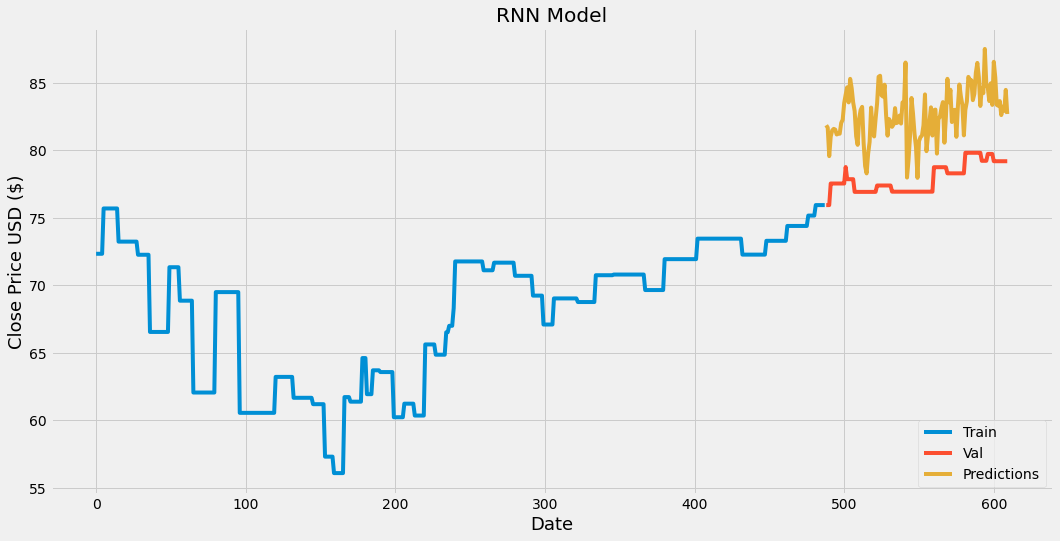

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**RNN Model with batch processing**

In [ ]:
#Training model with batch processing
model.fit(
    x_train,
    y_train,
    batch_size=15,
    epochs=10)

Epoch 1/10
29/29 [==============================] - 14s 482ms/step - loss: 0.0123 - accuracy: 0.0164
Epoch 2/10
29/29 [==============================] - 14s 471ms/step - loss: 0.0135 - accuracy: 0.0164
Epoch 3/10
29/29 [==============================] - 14s 483ms/step - loss: 0.0110 - accuracy: 0.0164
Epoch 4/10
29/29 [==============================] - 14s 474ms/step - loss: 0.0137 - accuracy: 0.0164
Epoch 5/10
29/29 [==============================] - 14s 471ms/step - loss: 0.0094 - accuracy: 0.0164
Epoch 6/10
29/29 [==============================] - 14s 474ms/step - loss: 0.0119 - accuracy: 0.0164
Epoch 7/10
29/29 [==============================] - 14s 476ms/step - loss: 0.0089 - accuracy: 0.0164
Epoch 8/10
29/29 [==============================] - 14s 471ms/step - loss: 0.0096 - accuracy: 0.0164
Epoch 9/10
29/29 [==============================] - 14s 475ms/step - loss: 0.0078 - accuracy: 0.0164
Epoch 10/10
29/29 [==============================] - 14s 476ms/step - loss: 0.0094 - accura

In [ ]:
#Test the train model using test data
predictions = model.predict(x_test) 
predictions = newScaler.inverse_transform(predictions)

In [ ]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.422946287689156

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


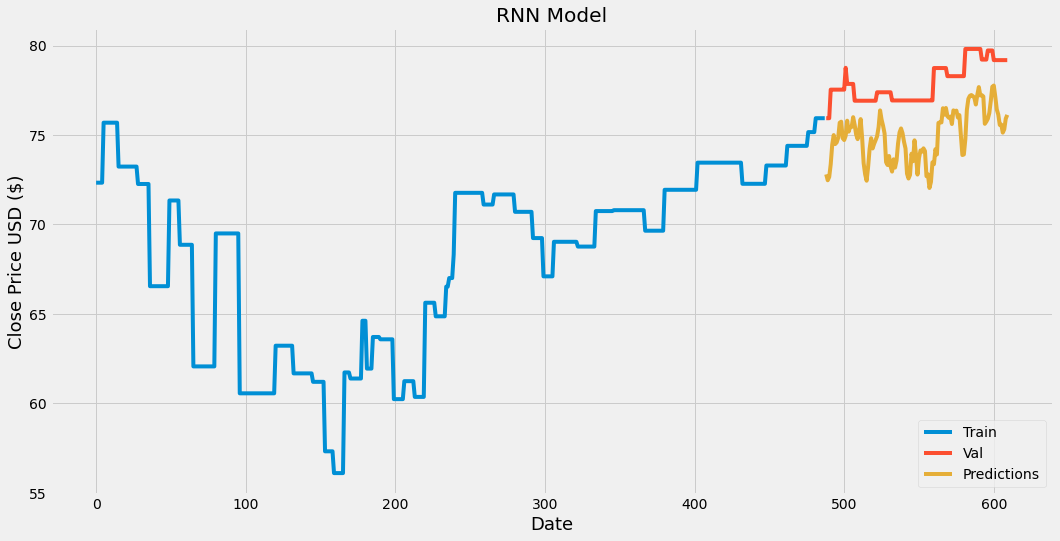

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('RNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()